# Requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, log_loss
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1) Exploration du dataset

In [2]:
df = pd.read_csv('data/train.csv')

### Check pour les categorical valeurs.

In [3]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Y
0,3215.0,206.0,8.0,127.0,14.0,5588.0,215.0,248.0,168.0,1057.0,T1,T29,1.0
1,3022.0,18.0,7.0,0.0,0.0,3012.0,215.0,226.0,148.0,1476.0,T1,T23,1.0
2,3008.0,18.0,19.0,382.0,92.0,4715.0,201.0,197.0,127.0,3616.0,T1,T29,1.0
3,2595.0,296.0,24.0,85.0,28.0,1252.0,144.0,224.0,216.0,780.0,T3,T33,6.0
4,3261.0,87.0,4.0,42.0,-2.0,3719.0,226.0,233.0,142.0,3784.0,T1,T38,7.0


On remarque que le dataset possède bien 2 categorical valeur qui sont les colonnes X11 et X12.

In [4]:
df = df.astype({'X11': 'category', 'X12': 'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40670 entries, 0 to 40669
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      40624 non-null  float64 
 1   X2      40630 non-null  float64 
 2   X3      40639 non-null  float64 
 3   X4      40636 non-null  float64 
 4   X5      40630 non-null  float64 
 5   X6      40622 non-null  float64 
 6   X7      40637 non-null  float64 
 7   X8      40637 non-null  float64 
 8   X9      40625 non-null  float64 
 9   X10     40634 non-null  float64 
 10  X11     40632 non-null  category
 11  X12     40632 non-null  category
 12  Y       40632 non-null  float64 
dtypes: category(2), float64(11)
memory usage: 3.5 MB


### Check pour les valeurs manquantes.

In [5]:
df.isna().sum()

X1     46
X2     40
X3     31
X4     34
X5     40
X6     48
X7     33
X8     33
X9     45
X10    36
X11    38
X12    38
Y      38
dtype: int64

On remarque également des valeurs manquantes dans le dataset.
Nous allons donc retirer les lignes qui possèdent des valeurs manquantes.

In [6]:
df.dropna(inplace=True)
df.isna().sum()

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
Y      0
dtype: int64

### Distriution des valeurs de la colonne X11.

In [7]:
df['X11'].value_counts()

T1    17953
T3    17691
T4     2487
T2     2041
Name: X11, dtype: int64

On remarque aussi que le nombre de T1 et de T3 est très grand par rapport au nombre de T2 et T4. Il faudra le prendre en compte pour plus tard.

### Distribution des valeurs de la colonne X12.

In [8]:
df['X12'].value_counts()

T29    7899
T23    3935
T32    3694
T33    3142
T22    2293
T10    2278
T12    2106
T30    2096
T31    1788
T24    1454
T13    1262
T38    1048
T39     965
T11     901
T4      871
T40     641
T20     614
T2      535
T6      419
T3      316
T19     284
T17     240
T26     184
T1      181
T16     170
T35     127
T18     125
T34     110
T5       90
T9       84
T27      82
T28      63
T21      52
T14      49
T25      25
T37      18
T8       14
T36       9
T7        7
T15       1
Name: X12, dtype: int64

On remarque à nouveau que certaines valeurs sont fortement présentes (T29) et que d'autres sont très rare (T15).

In [9]:
df['Y'].value_counts()

2.0    19577
1.0    14648
3.0     2475
7.0     1418
6.0     1206
5.0      657
4.0      191
Name: Y, dtype: int64

Peu de prédiction pour le 4.0.
Difficultés pour pouvoir les identifier.

### Recherche des meilleurs variables.

In [10]:
X = df.drop(['Y'], axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=0
)

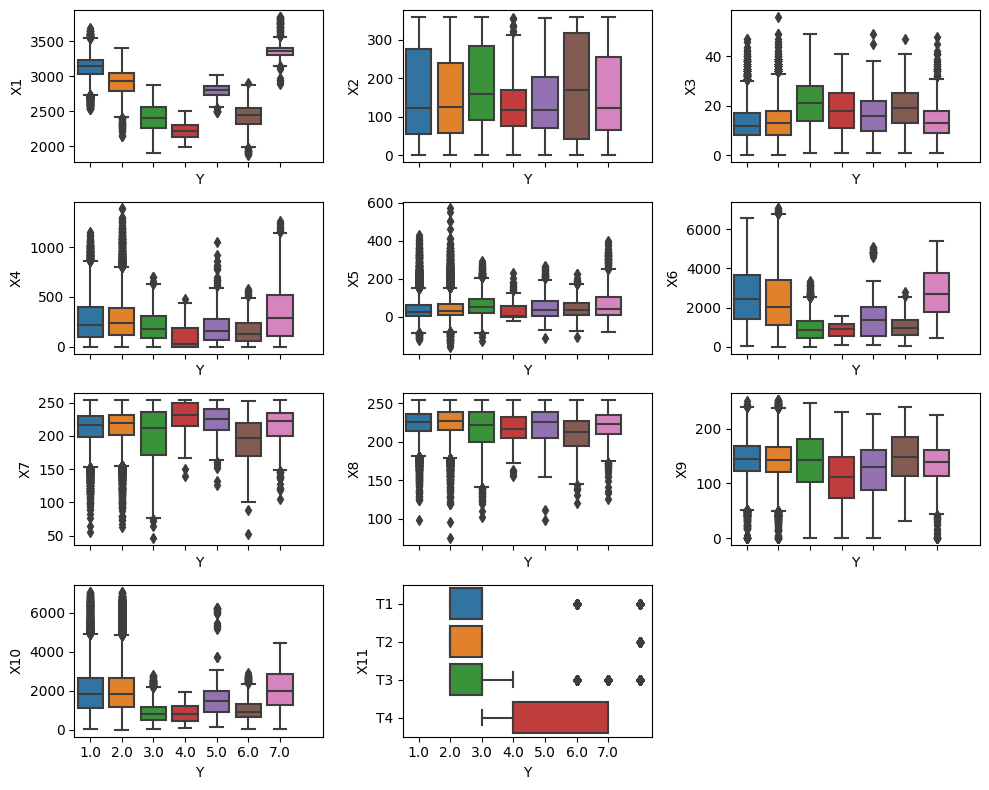

In [52]:
fig, axes = plt.subplots(4, 3, figsize=(10, 8), sharex=True)
for column, axis in zip(X_train.columns, axes.flatten()):
    sns.boxplot(x=y_train, y=X_train[column], ax=axis)
axes.flatten()[-1].set_visible(False)
fig.tight_layout()

A première vue, "X1", "X2" et "X6" sont les colonnes les plus intéressantes.

In [13]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), hue='Y')

### Normaliser et one hot encoding pour les variables categorical.

In [11]:
#One hot encoding
dummies = pd.get_dummies(X_train[["X11", "X12"]], drop_first=True)
X_train = X_train.drop(["X11", "X12"], axis=1)
X_train = pd.concat([X_train, dummies], axis=1)

dummies = pd.get_dummies(X_test[["X11", "X12"]], drop_first=True)
X_test = X_test.drop(["X11", "X12"], axis=1)
X_test = pd.concat([X_test, dummies], axis=1)

# Normaliser.
X_scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns)

# Différentes ML.

## Paramètres

In [12]:
default_grid_params = dict(n_iter=100, cv=5, n_jobs=4)

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 14, 20, 50, 100, 200, 500, 1000],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

param_grid_lr = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
}

param_grid_rf = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'loss': ['log_loss'],
    'learning_rate': [0.02, 0.1, 0.5],
    'n_estimators': [100, 200, 300],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [None, 2, 5, 10],
}

## KNN

In [82]:
# Model
knn = KNeighborsClassifier()
model = RandomizedSearchCV(knn, param_grid_knn, scoring='neg_log_loss', **default_grid_params).fit(X_train, y_train)

# Accuracy
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Log loss
y_pred_proba = model.predict_proba(X_test)

c:\Users\benoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 44 is smaller than n_iter=100. Running 44 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy: 0.7910392034847542


In [88]:
print(f'Log loss: {log_loss(y_test, y_pred_proba)}')

Log loss: 0.5461428488465225


## Logistic Regression

## Random Forest

## Gradient Boosting

## ???

## Test for Kaggle

In [ ]:
pred_prob_test = pd.DataFrame(model.predict_proba(X_test_sub))
pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)
pred_prob_test.to_csv("benchmark.csv", index=False)